# 11. Asian Option Pricing using Neural Path Integral

This notebook demonstrates **Neural Importance Sampling** for **Arithmetic Asian Call Options**.

## Asian Option
The payoff depends on the arithmetic average of the asset price over the path:
$$ \text{Payoff} = \max(A_T - K, 0) $$
where $A_T = \frac{1}{T} \int_0^T S_t dt$.

## Objective
Since the payoff depends on the running average $A_t$, the Neural Control Policy needs to know $A_t$ in addition to $S_t$ and $v_t$.
We have updated `DriftNet` to take $(t, S_t, v_t, A_t)$ as input.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from src.physics_engine import MarketSimulator
from src.neural_engine import NeuralImportanceSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 1. Environment & Option Parameters
We use the **Heston Model** which adds stochastic volatility complexity.

**Bias Correction**: We reduce `dt` to 0.002 (500 steps) to handle the strong control force utilized by the network.

In [2]:
# Option Parameters (Arithmetic Asian Call)
S0 = 100.0
K = 100.0     # ATM
T = 1.0
r = 0.05
dt = 0.002    # 500 steps (Finer discretization)

# Heston Parameters
kappa = 2.0
theta = 0.04
xi = 0.3
rho = -0.7

sim = MarketSimulator(mu=r, kappa=kappa, theta=theta, xi=xi, rho=rho, device=device)

## 2. Standard Monte Carlo (Benchmark)
We run a high-precision MC simulation to establish the ground truth price and variance.

In [3]:
print("Running Standard Monte Carlo...")
N_mc = 100000
batch_size = 10000
prices_mc = []

with torch.no_grad():
    for _ in range(N_mc // batch_size):
        # simulate_controlled returns tuple: (S, v, log_w, hit, running_int_S)
        S, _, _, _, running_int_S = sim.simulate_controlled(
            S0=S0, v0=sim.theta, T=T, dt=dt, num_paths=batch_size, 
            control_fn=None  # Standard MC
        )
        
        # Calculate Average Price A_T
        A_T = running_int_S / T
        
        # Asian Call Payoff
        payoff = torch.maximum(A_T - K, torch.tensor(0.0, device=device))
        
        discounted_payoff = torch.exp(torch.tensor(-r*T, device=device)) * payoff
        prices_mc.extend(discounted_payoff.cpu().numpy())

mean_mc = np.mean(prices_mc)
std_mc = np.std(prices_mc) / np.sqrt(len(prices_mc))
sigma_mc = np.std(prices_mc)  # Std per path
print(f"Standard MC Asian Price: {mean_mc:.4f} +/- {1.96*std_mc:.4f} (95% CI)")
print(f"Standard MC StdDev (per path): {sigma_mc:.4f}")

Running Standard Monte Carlo...
Standard MC Asian Price: 5.7597 +/- 0.0421 (95% CI)
Standard MC StdDev (per path): 6.7967


## 3. Training Neural Control (Variance Reduction)
We train the network to minimize the second moment of the weighted payoff.
For Asian Call, OTM paths have 0 payoff (0 variance). ITM paths contribute variance.
The optimal control should stabilize the average price.

Training Neural Control for Asian Option...
Iter 0: Loss = 88.583023, Price Est = 5.7414
Iter 30: Loss = 64.419853, Price Est = 6.0218
Iter 60: Loss = 62.969639, Price Est = 6.0349
Iter 90: Loss = 62.363949, Price Est = 6.0717
Iter 120: Loss = 54.658634, Price Est = 6.0570
Iter 150: Loss = 55.600979, Price Est = 6.2435
Iter 180: Loss = 53.288490, Price Est = 6.2056
Iter 210: Loss = 53.297314, Price Est = 6.2077
Iter 240: Loss = 52.626019, Price Est = 6.1532
Iter 270: Loss = 52.768291, Price Est = 6.1917
Iter 300: Loss = 53.250019, Price Est = 6.2496


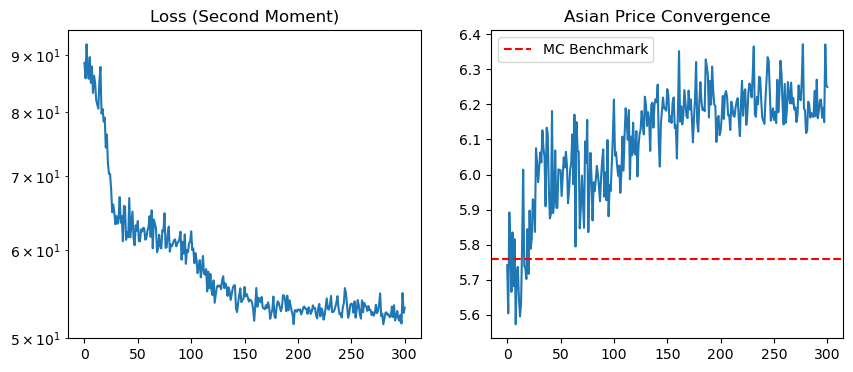

In [4]:
sampler = NeuralImportanceSampler(sim, hidden_dim=64)
# Learning Rate - conservative to avoid instability
optimizer = torch.optim.Adam(sampler.control_net.parameters(), lr=0.001)

losses = []
prices_history = []

print("Training Neural Control for Asian Option...")
for i in range(301):
    sampler.control_net.train()
    optimizer.zero_grad()
    
    # Training also uses finer steps
    dt_train = dt 
    control_fn = sampler.get_control_fn()
    
    # Run Simulation with Control
    S, _, log_weights, _, running_int_S = sim.simulate_controlled(
        S0=S0, v0=sim.theta, T=T, dt=dt_train, num_paths=3000, 
        control_fn=control_fn
    )
    
    # Asian Payoff
    A_T = running_int_S / T
    payoff = torch.maximum(A_T - K, torch.tensor(0.0, device=device))
    
    # Weighted Payoff
    weighted_payoff = payoff * torch.exp(log_weights)
    
    # Loss: Second Moment
    loss = torch.mean(weighted_payoff ** 2)
    
    loss.backward()
    # Clip gradients for stability
    torch.nn.utils.clip_grad_norm_(sampler.control_net.parameters(), max_norm=1.0)
    optimizer.step()
    
    # Monitor Price Estimate (Discounted)
    price_est = torch.mean(weighted_payoff).item() * np.exp(-r*T)
    
    losses.append(loss.item())
    prices_history.append(price_est)
    
    if i % 30 == 0:
        print(f"Iter {i}: Loss = {loss.item():.6f}, Price Est = {price_est:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss (Second Moment)')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(prices_history)
plt.axhline(mean_mc, color='r', linestyle='--', label='MC Benchmark')
plt.title('Asian Price Convergence')
plt.legend()
plt.show()

## 4. Final Verification
Compare Variance of Standard MC vs Neural IS.

In [5]:
N_eval = 50000

# 1. Neural IS
with torch.no_grad():
    sampler.control_net.eval()
    control_fn = sampler.get_control_fn()
    S, _, log_w, _, running_int_S = sim.simulate_controlled(
        S0=S0, v0=sim.theta, T=T, dt=dt, num_paths=N_eval, control_fn=control_fn
    )
    
    A_T = running_int_S / T
    payoff = torch.maximum(A_T - K, torch.tensor(0.0, device=device))
    weighted_payoff = payoff * torch.exp(log_w) * torch.exp(torch.tensor(-r*T, device=device))
    
    neural_mean = torch.mean(weighted_payoff).item()
    neural_std = torch.std(weighted_payoff).item()

# 2. Standard MC (Same N)
with torch.no_grad():
    S, _, _, _, running_int_S = sim.simulate_controlled(
        S0=S0, v0=sim.theta, T=T, dt=dt, num_paths=N_eval, control_fn=None
    )
    
    A_T = running_int_S / T
    payoff = torch.maximum(A_T - K, torch.tensor(0.0, device=device))
    val = payoff * torch.exp(torch.tensor(-r*T, device=device))
    
    mc_mean = torch.mean(val).item()
    mc_std = torch.std(val).item()

print(f"Results (N={N_eval}):")
print(f"Standard MC: {mc_mean:.4f} +/- {1.96 * mc_std / np.sqrt(N_eval):.4f} (StdDev: {mc_std:.4f})")
print(f"Neural IS  : {neural_mean:.4f} +/- {1.96 * neural_std / np.sqrt(N_eval):.4f} (StdDev: {neural_std:.4f})")

if neural_std > 1e-9:
    ratio = (mc_std / neural_std)**2
    print(f"\nVariance Reduction Ratio: {ratio:.2f}x")
else:
    print("\nVariance Reduction Ratio: Undefined (Neural StdDev ~= 0)")

Results (N=50000):
Standard MC: 5.7384 +/- 0.0598 (StdDev: 6.8227)
Neural IS  : 6.2457 +/- 0.0261 (StdDev: 2.9786)

Variance Reduction Ratio: 5.25x
